Kaggle dataset: https://www.kaggle.com/code/jatingoyal123/hate-offensive-language

In [43]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Extend the display width 
pd.options.display.max_colwidth = 100


In [44]:
pd.read_csv('./data/labeled_data.csv').head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...


First we clean the dataframe by removing the unnecessary columns that map to 'class' column which tells us what type the tweet is. We also get rid of the duplicated id column.

In [45]:
# Read csv file
df_tweets = pd.read_csv('./data/labeled_data.csv')

# Create a dictionary to map the labels to numbers
label_dict = {0: 'Hate speech', 1: 'Offensive language',2: 'Neither'}

# Drop the columns we don't need
df_tweets = df_tweets.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# Rename the columns
df_tweets = df_tweets.rename(columns={'tweet': 'text', 'class.1': 'label'})

print(f"Shape of the dataframe: {df_tweets.shape}")

Shape of the dataframe: (24783, 2)


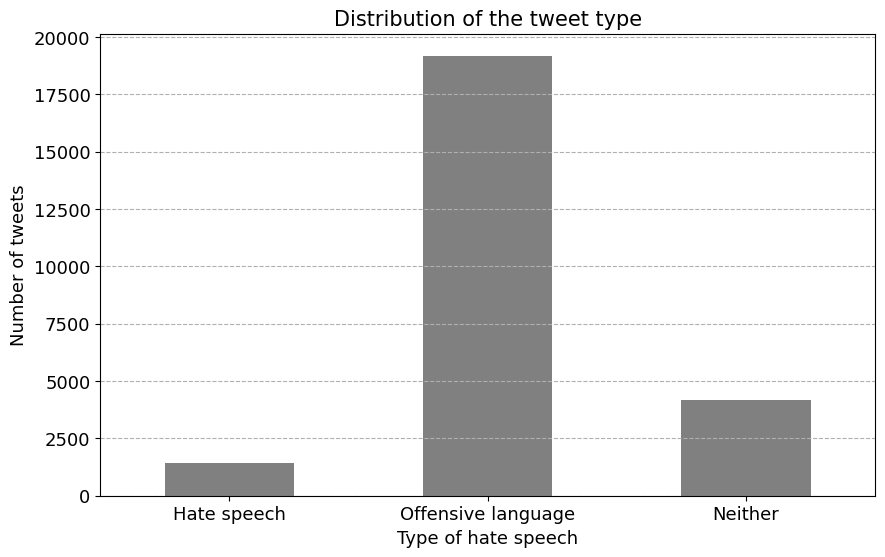

In [46]:
# Plot the distribution of the class column and sort the values
ax = df_tweets['class'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color='gray', fontsize=13)

# Get current ax tics 
ax_tics = ax.get_xticks()

# Add the title and labels
ax.set_title('Distribution of the tweet type', fontsize=15)
ax.set_ylabel('Number of tweets', fontsize=13)
ax.set_xlabel('Type of hate speech', fontsize=13)

# Add grid lines
ax.grid(axis='y', linestyle='--')


# Set the xticts with the class names
ax.set_xticklabels([label_dict[i] for i in range(3)], rotation=0)

# Save the plot into slike folder
plt.savefig('./slike/distribution-bar.png')


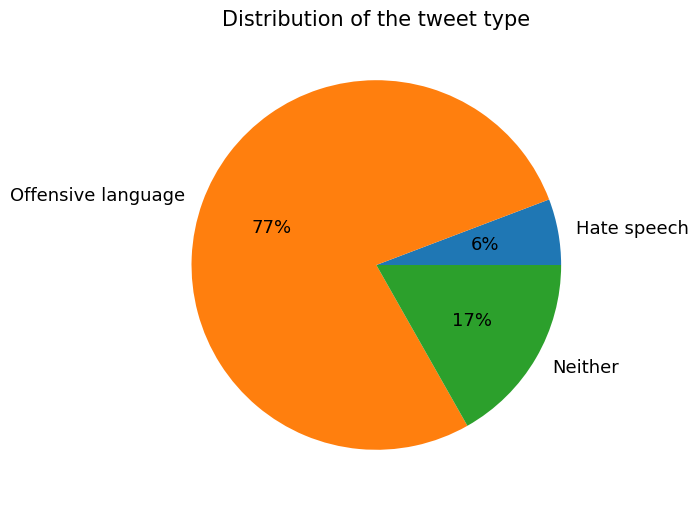

In [47]:
# Plot a pie chart of the classess by using labels from label_dict
df_tweets['class'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%', labels=[label_dict[i] for i in range(3)], figsize=(10, 6), fontsize=13)


# Label the pie chart
plt.ylabel('')
plt.title('Distribution of the tweet type', fontsize=15)


# Save the plot into slike folder
plt.savefig('./slike/distribution-pie.png')


In [48]:
# Print the distribution of classes
print(df_tweets['class'].value_counts().sort_index())

0     1430
1    19190
2     4163
Name: class, dtype: int64


For the sake of classification we will join hate with offensive speech into a single class. We will also move the 'neither' class from 2 to 0, for easier usage later.

In [49]:
# Join the hate speech and offensive language classes
df_tweets['class'] = df_tweets['class'].replace(0, 1)
# Move the class 2 to class 0
df_tweets['class'] = df_tweets['class'].replace(2, 0)

# Delete the item where class is 0 from label_dicŽt
label_dict[0] = label_dict[2]
del label_dict[2]

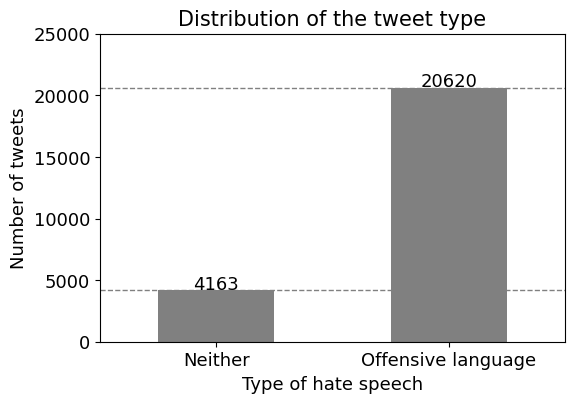

In [50]:
# Plot the distribution of the class column and sort the values
ax = df_tweets['class'].value_counts().sort_index().plot(kind='bar', figsize=(6, 4), color='gray', fontsize=13)

# Get current ax tics 
ax_tics = ax.get_xticks()

# Add the title and labels
ax.set_title('Distribution of the tweet type', fontsize=15)
ax.set_ylabel('Number of tweets', fontsize=13)
ax.set_xlabel('Type of hate speech', fontsize=13)


# Set the yticks 
ax.set_yticks([5000 * i for i in range(6)])

# Create horizontal lines for both values of the class column
for i in range(2):
    ax.axhline(df_tweets['class'].value_counts().sort_index()[i], color='gray', linestyle='dashed', linewidth=1)
    # Add the value on the line
    ax.text(ax_tics[i], df_tweets['class'].value_counts().sort_index()[i] + 100, df_tweets['class'].value_counts().sort_index()[i], fontsize=13, ha='center')
    

# Set the xticts with the class names
_=ax.set_xticklabels([label_dict[i] for i in range(2)], rotation=0)

# Save plt
plt.savefig('./slike/distribution-merged-bar.png')

Now we clean the tweets by transforming and normalizing them

In [51]:
import re
import nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joksz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    text = text.replace('rt', '')
    return text

In [53]:
# Apply the clean_text function to the text column
df_tweets['text'] = df_tweets['text'].apply(clean_text)

In [54]:
from wordcloud import WordCloud, STOPWORDS

In [55]:
def make_wordcloud(df, saveplot=False):
    tweet_words=""
    for val in df.text: 
        val = str(val).lower()

      
        tweet_words += val
        
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words(),min_font_size = 10)
    
    wordcloud.generate(tweet_words)

    plt.figure(figsize = (10, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    # Save the plot
    if saveplot:
        plt.savefig('./slike/wordcloud.png')

    plt.show()


Offensive language


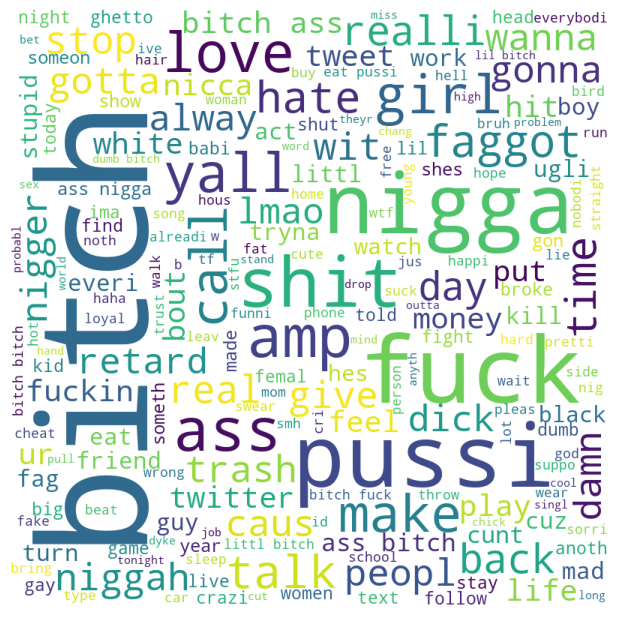

Language not labeled as offensive


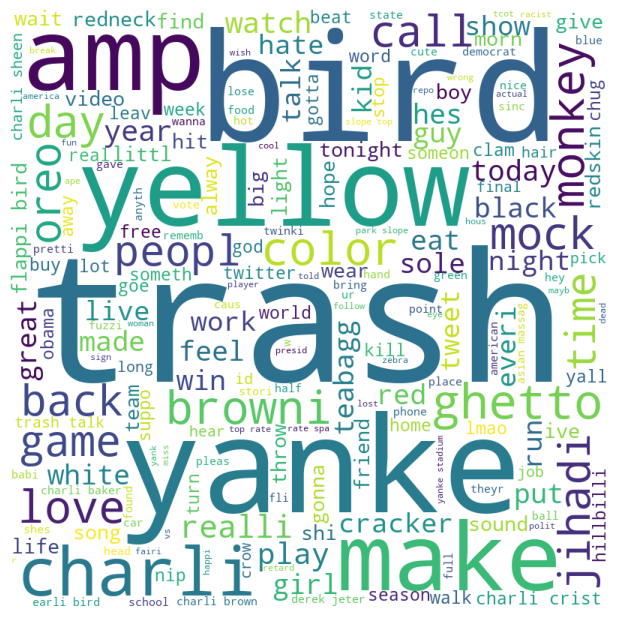

In [56]:
print("Offensive language")
make_wordcloud(df_tweets[df_tweets['class']==1])

print("Language not labeled as offensive")
make_wordcloud(df_tweets[df_tweets['class']==0], saveplot=True)

In [66]:
x=df_tweets['text']
y=df_tweets['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train) / (len(x_train) + len(x_test)))

0.749989912439979


In [58]:
count = CountVectorizer(stop_words='english', ngram_range=(1,5))
x_train_vectorizer=count.fit_transform(x_train)

In [59]:
x_test_vectorizer=count.transform(x_test)

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [64]:
model_vectorizer= MultinomialNB().fit(x_train_vectorizer, y_train)
prediction_vectorizer=model_vectorizer.predict(x_test_vectorizer)

conf = confusion_matrix(y_test, prediction_vectorizer)

conf_matrix_df = pd.DataFrame(conf, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
conf_matrix_df.style.background_gradient(cmap='Blues')
print(conf_matrix_df)


        Pred 0  Pred 1
True 0     352     689
True 1      21    5134


In [71]:
import xgboost as xgb
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

C:\Users\joksz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [72]:
xgb_model_vectorizer = xgb_model.fit(x_train_vectorizer, y_train)
xgb_predictions_vectorizer=xgb_model_vectorizer.predict(x_test_vectorizer)
print(confusion_matrix(y_test,xgb_predictions_vectorizer))
print (classification_report(y_test, xgb_predictions_vectorizer))

[[ 993   48]
 [ 358 4797]]
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1041
           1       0.99      0.93      0.96      5155

    accuracy                           0.93      6196
   macro avg       0.86      0.94      0.89      6196
weighted avg       0.95      0.93      0.94      6196

